In [1]:
spark

In [2]:
# Create Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Feature_Engineering_Modeling').getOrCreate()

24/05/16 09:59:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
# set the spark logging level to only show errors
sc.setLogLevel("ERROR")

In [4]:
# Import libraries
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

In [5]:
# Read in the cleaned data from GCS
bucket = "my-bigdata-project-bg"

filename = 'cleaned_steam_reviews.parquet'

output_file_path = f'gs://{bucket}/cleaned/{filename}'

sdf = spark.read.parquet(output_file_path)

In [6]:
sdf = sdf.filter(sdf['language'] == 'english')

In [7]:
sample_sdf = sdf.sample(False, 0.15)

In [8]:
# Feature Engineering Review text using Tokenizer
from pyspark.ml.feature import Tokenizer, RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol="review", outputCol="words", pattern="\\w+", gaps=False)
words_df = regexTokenizer.transform(sample_sdf)
words_df.select("review", "words").show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
# Take a sequence of words and map them on a vector to find term frequency using HashingTf
from pyspark.ml.feature import HashingTF
hashingTF = HashingTF(numFeatures=4096, inputCol="words", outputCol="word_features")
term_freq_df = hashingTF.transform(words_df)
term_freq_df.select(['words','word_features']).show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
# Using IDF to measure how important a word is
from pyspark.ml.feature import IDF
idf = IDF(inputCol='word_features', outputCol="idf_features", minDocFreq=1)
idfModel = idf.fit(term_freq_df)
scaled_df = idfModel.transform(term_freq_df)
scaled_df.select("idf_features").show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
# Install Vader Sentiment Analysis 
%pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
# import library
from pyspark.sql.types import DoubleType
import nltk
nltk.download('vader_lexicon')

# Vader for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

# Create function to perform sentiment analysis on some text
def sentiment_analysis(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['compound']

# Turn our funciton into a UDF
sentiment_analysis_udf = udf(sentiment_analysis, DoubleType())

# Apply the sentiment analysis function to the review column
# create a new column sentiment_score
scaled_df = scaled_df.withColumn("sentiment_score", 
                            sentiment_analysis_udf(scaled_df['review']))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [13]:
# Display reviews with high sentiment score
scaled_df.select('review', 'sentiment_score').filter(scaled_df['sentiment_score'] > 0.9).show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|review                                                                                                                                                                                                                          

In [14]:
# Display reviews with low sentiment score
scaled_df.select('review', 'sentiment_score').filter(scaled_df['sentiment_score'] < -0.9).show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

MODELING

In [15]:
# Import all necessary PySpark functions and modules
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
# Import the logistic regression model
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
# Import the evaluation module
from pyspark.ml.evaluation import *
# Import the model tuning module
from pyspark.ml.tuning import *
import numpy as np

In [16]:
# Create a label =1 if True, =0 otherwise
sdf = scaled_df.withColumn("label", when(scaled_df.recommended == True, 1.0).otherwise(0.0))

In [17]:
# Create Assembler for individual feature vectors
assembler = VectorAssembler(inputCols=['idf_features', 'sentiment_score'], outputCol='features')

In [18]:
# Determine Logistic Regression Weights to handle class imbalance
#source: https://gist.github.com/FyzHsn/420a7cceda8623c42c097175b001fef0
from itertools import chain

class_count_df = sdf.groupby('label').agg({'label': 'count'})
n_1 = class_count_df.filter(sdf.label == '1') \
                    .select("count(label)").collect()[0][0]
n_0 = class_count_df.filter(sdf.label == '0') \
                    .select("count(label)").collect()[0][0]

w_1 = (n_0 + n_1) / (2.0 * n_1)
w_0 = (n_0 + n_1) / (2.0 * n_0)

class_weights = {0: w_0, 1: w_1}

mapping_expr = create_map([lit(x) for x in chain(*class_weights.items())])
sdf = sdf.withColumn("weights", mapping_expr.getItem(col("label")))


/usr/lib/spark/python/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


In [19]:
# Split data into training and test sets
trainingData, testData = sdf.randomSplit([0.7, 0.3], seed=42)

In [20]:
# Create a LogisiticRegression Estimator
lr = LogisticRegression(weightCol='weights')

In [21]:
# Create pipeline
review_pipe = Pipeline(stages=[assembler, lr])

In [ ]:
# Build the parameter grid
# Create a grid to hold hyperparameters 
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
grid = grid.addGrid(lr.elasticNetParam, [0, 0.5, 1])

# Build the parameter grid
grid = grid.build()

# How many models to be tested
print('Number of models to be tested: ', len(grid))

# Create a BinaryClassificationEvaluator to evaluate how well the model works
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator=review_pipe, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=3)

# Train the models
cv  = cv.fit(trainingData)

In [23]:
# Test the predictions
predictions = cv.transform(testData)

# Calculate AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

# Create the confusion matrix
predictions.groupby('label').pivot('prediction').count().sort('label').fillna(0).show()
cm = predictions.groupby('label').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(cm):
    tn = cm[0][1]                # True Negative
    fp = cm[0][2]                # False Positive
    fn = cm[1][1]                # False Negative
    tp = cm[1][2]                # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Accuracy, Precision, Recall, F1 Score")
print( calculate_recall_precision(cm) )

24/05/16 10:23:42 WARN DAGScheduler: Broadcasting large task binary with size 1041.1 KiB


AUC: 0.9194084742185035


24/05/16 10:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1046.1 KiB
24/05/16 10:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1003.4 KiB
24/05/16 10:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1003.2 KiB
24/05/16 10:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1049.2 KiB
24/05/16 10:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
24/05/16 10:28:46 WARN DAGScheduler: Broadcasting large task binary with size 1007.5 KiB


+-----+-----+------+
|label|  0.0|   1.0|
+-----+-----+------+
|  0.0|38626|  8526|
|  1.0|45359|339484|
+-----+-----+------+



24/05/16 10:28:46 WARN DAGScheduler: Broadcasting large task binary with size 1046.1 KiB
24/05/16 10:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1003.4 KiB
24/05/16 10:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1003.2 KiB
24/05/16 10:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1049.2 KiB
24/05/16 10:32:22 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
24/05/16 10:32:22 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB


Accuracy, Precision, Recall, F1 Score
(0.1247352399912036, 0.024499295997241457, 0.18081947743467933, 0.04315192250266979)


LogisticRegression_51c8363c590f__aggregationDepth 2
LogisticRegression_51c8363c590f__elasticNetParam 0.0
LogisticRegression_51c8363c590f__family auto
LogisticRegression_51c8363c590f__featuresCol features
LogisticRegression_51c8363c590f__fitIntercept True
LogisticRegression_51c8363c590f__labelCol label
LogisticRegression_51c8363c590f__maxBlockSizeInMB 0.0
LogisticRegression_51c8363c590f__maxIter 100
LogisticRegression_51c8363c590f__predictionCol prediction
LogisticRegression_51c8363c590f__probabilityCol probability
LogisticRegression_51c8363c590f__rawPredictionCol rawPrediction
LogisticRegression_51c8363c590f__regParam 0.0
LogisticRegression_51c8363c590f__standardization True
LogisticRegression_51c8363c590f__threshold 0.5
LogisticRegression_51c8363c590f__tol 1e-06
LogisticRegression_51c8363c590f__weightCol weights


24/05/16 10:32:26 WARN DAGScheduler: Broadcasting large task binary with size 1045.4 KiB


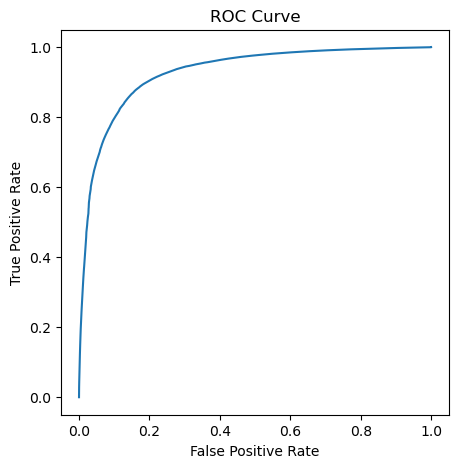

In [24]:
# Look at the parameters for the best model that was evaluated from the grid
parammap = cv.bestModel.stages[1].extractParamMap()

for p, v in parammap.items():
    print(p, v)

# Grab the model from Stage 1 of the pipeline
mymodel = cv.bestModel.stages[1]

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(mymodel.summary.roc.select('FPR').collect(),
         mymodel.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.savefig("roc1.png")
plt.show()

Data Visuals

In [25]:
#import lib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

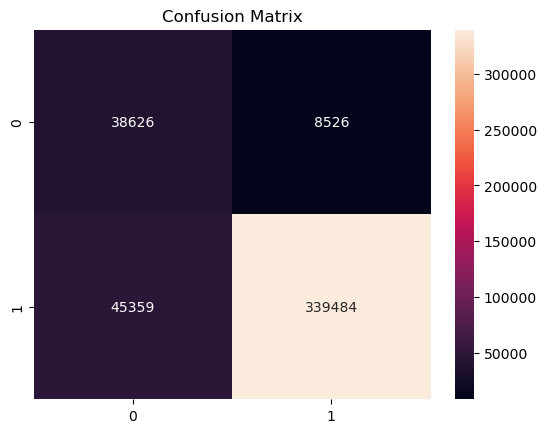

In [30]:
# Creating Confusion Matrix with seaborn
'''
+-----+-----+------+
|label|  0.0|   1.0|
+-----+-----+------+
|  0.0|38626|  8526|
|  1.0|45359|339484|
+-----+-----+------+
'''

cf_matrix = ([38626, 8526],
             [45359, 339484])

sns.heatmap(cf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()


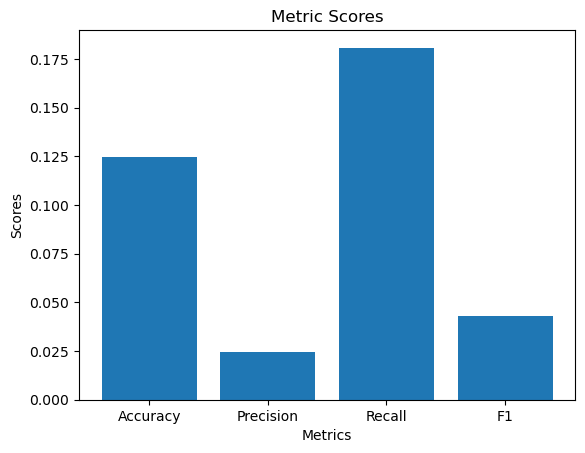

In [31]:
# Bar plot showing the metric scores
'''
Accuracy, Precision, Recall, F1 Score
(0.1247352399912036, 0.024499295997241457, 0.18081947743467933, 0.04315192250266979)
'''

metric = ['Accuracy', 'Precision', 'Recall', 'F1']
scores = [0.1247352399912036, 0.024499295997241457, 0.18081947743467933, 0.04315192250266979]

plt.bar(metric, scores)
plt.title('Metric Scores')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.show()

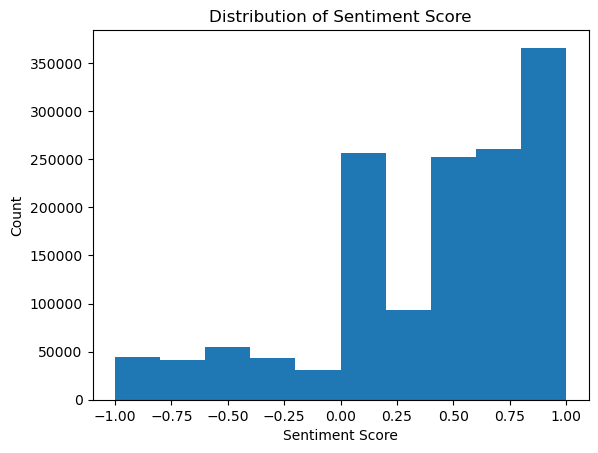

In [28]:
# Counting the sentiment score using a histogram
sentiment_score_sdf = sdf.select('sentiment_score')
sentiment_df = sentiment_score_sdf.toPandas()

plt.hist(sentiment_df['sentiment_score'])
plt.title('Distribution of Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

24/05/16 10:36:05 WARN DAGScheduler: Broadcasting large task binary with size 1033.1 KiB


<function matplotlib.pyplot.show(close=None, block=None)>

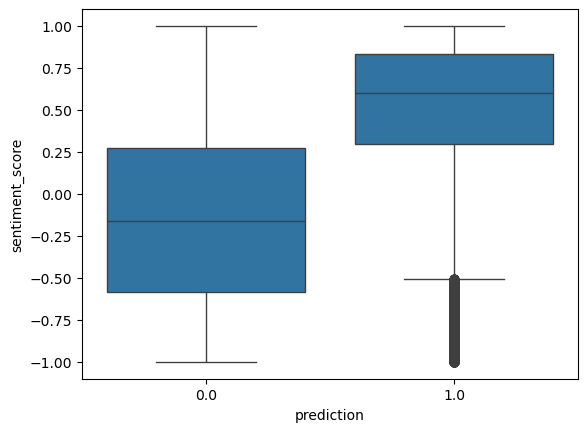

In [29]:
# Creating boxplot to see sentiment score and predicted label
sentiment_prediction_sdf = predictions.select('sentiment_score', 'label', 'prediction')
sentiment_pred_df = sentiment_prediction_sdf.toPandas()

sns.boxplot(x='prediction', y='sentiment_score', data=sentiment_pred_df)
plt.show